In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [2]:
# Step 2: Data Preprocessing
# Merge transactions with product data
transactions = transactions.merge(products, on="ProductID", how="left")

# Merge with customer data
data = transactions.merge(customers, on="CustomerID", how="left")

In [3]:
# Step 3: Feature Engineering
# Calculate total spending per customer
total_spending = data.groupby("CustomerID")["TotalValue"].sum().rename("TotalSpending")

# Calculate purchase frequency per customer
purchase_frequency = data.groupby("CustomerID")["TransactionID"].nunique().rename("PurchaseFrequency")

# Calculate average transaction value per customer
average_transaction_value = (total_spending / purchase_frequency).rename("AvgTransactionValue")

# Calculate category preferences (percentage of spending in each category)
category_spending = data.groupby(["CustomerID", "Category"])['TotalValue'].sum().unstack(fill_value=0)
category_spending = category_spending.div(category_spending.sum(axis=1), axis=0)

# Combine features into a single dataframe
customer_features = pd.concat([
    total_spending,
    purchase_frequency,
    average_transaction_value,
    category_spending
], axis=1).fillna(0)

In [4]:
# Step 4: Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

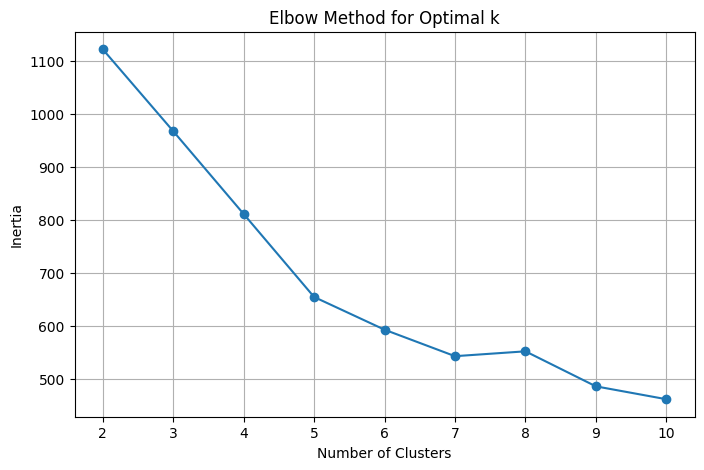

In [5]:
# Step 5: Optimal Number of Clusters using Elbow Method
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()

In [6]:
# Step 6: Apply KMeans Clustering
optimal_k = 4  # Based on the Elbow plot, update this value as needed
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

customer_features['Cluster'] = clusters

In [7]:
# Step 7: Evaluate Clustering
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.450180471244534


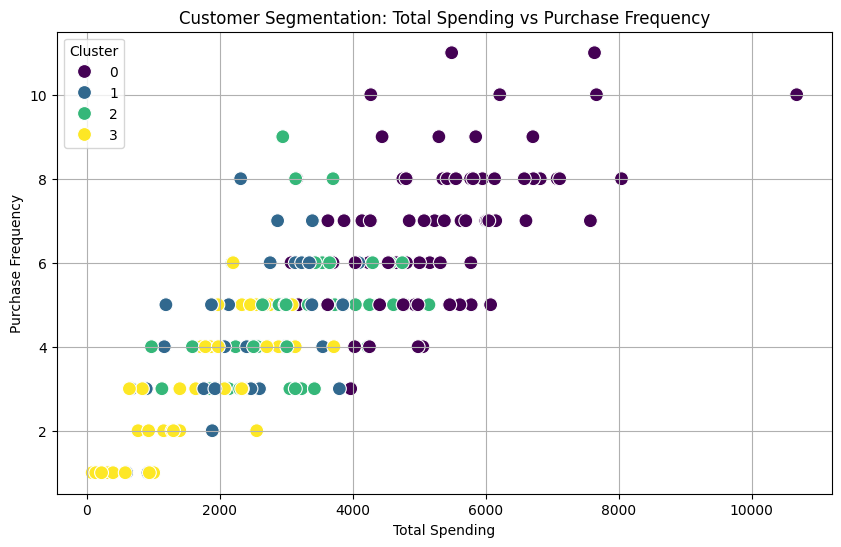

In [8]:
# Step 8: Visualize Clusters
# Visualize total spending vs purchase frequency colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_features['TotalSpending'],
    y=customer_features['PurchaseFrequency'],
    hue=customer_features['Cluster'],
    palette='viridis',
    s=100
)
plt.title("Customer Segmentation: Total Spending vs Purchase Frequency")
plt.xlabel("Total Spending")
plt.ylabel("Purchase Frequency")
plt.legend(title="Cluster")
plt.grid()
plt.show()

In [9]:
# Step 9: Save Results
customer_features.to_csv("CustomerSegments.csv")
print("Customer segmentation results saved to 'CustomerSegments.csv'")

Customer segmentation results saved to 'CustomerSegments.csv'


In [11]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=f23ad254cfead39188fa48900e3e053daf0af2c97ffc83847cc3d60e14faedd0
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [15]:
from fpdf import FPDF
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, 'Customer Segmentation Report', border=0, ln=True, align='C')
        self.ln(10)

    def chapter_title(self, chapter_title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, chapter_title, ln=True)
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

    def add_image(self, image_path, x, y, w, h):
        self.image(image_path, x=x, y=y, w=w, h=h)

# Step 10: Generate PDF Report
def generate_pdf_report(customer_features, scaled_features, clusters, db_index, optimal_k):
    """
    Generate a PDF report on clustering results.
    """
    # Initialize PDF
    pdf = PDF()
    pdf.add_page()

    # Title Page
    pdf.set_font('Arial', 'B', 16)
    pdf.cell(0, 10, 'Customer Segmentation Report', ln=True, align='C')
    pdf.ln(10)

    # Metrics Summary
    silhouette_avg = silhouette_score(scaled_features, clusters)
    pdf.chapter_title("Summary of Metrics")
    metrics_text = (
        f"Number of Clusters Formed: {optimal_k}\n"
        f"Davies-Bouldin Index: {db_index:.4f}\n"
        f"Silhouette Score: {silhouette_avg:.4f}\n"
    )
    pdf.chapter_body(metrics_text)

    # Cluster-wise Statistics
    pdf.chapter_title("Cluster-wise Statistics")
    cluster_summary = customer_features.groupby("Cluster").agg({
        'TotalSpending': ['mean', 'std'],
        'PurchaseFrequency': ['mean', 'std'],
        'AvgTransactionValue': ['mean', 'std']
    })
    cluster_summary_text = cluster_summary.to_string()
    pdf.chapter_body(cluster_summary_text)

    # Visualizations
    pdf.chapter_title("Visualizations")

    # Visualization 1: Scatter Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=customer_features['TotalSpending'],
        y=customer_features['PurchaseFrequency'],
        hue=customer_features['Cluster'],
        palette='viridis',
        s=100
    )
    plt.title("Customer Segmentation: Total Spending vs Purchase Frequency")
    plt.xlabel("Total Spending")
    plt.ylabel("Purchase Frequency")
    plt.legend(title="Cluster")
    plt.grid()
    scatter_path = "Cluster_Visualization.png"
    plt.savefig(scatter_path)
    plt.close()
    pdf.add_image(scatter_path, x=10, y=pdf.get_y(), w=190, h=80)
    pdf.ln(90)

    # Visualization 2: Box Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y='TotalSpending', data=customer_features, palette='viridis')
    plt.title("Total Spending Distribution by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Total Spending")
    plt.grid()
    boxplot_path = "Cluster_Spending_Distribution.png"
    plt.savefig(boxplot_path)
    plt.close()
    pdf.add_image(boxplot_path, x=10, y=pdf.get_y(), w=190, h=80)

    # Save PDF
    pdf.output("Customer_Segmentation_Report.pdf")
    print("PDF report generated: 'Customer_Segmentation_Report.pdf'")

# Call the function to generate the PDF report
generate_pdf_report(customer_features, scaled_features, clusters, db_index, optimal_k)

<ipython-input-15-5116ef9d2f0e>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='TotalSpending', data=customer_features, palette='viridis')


PDF report generated: 'Customer_Segmentation_Report.pdf'
